In [1]:
import os
import pandas as pd
from PIL import Image

image_dir = "/Users/nissanthneelakandanabirami/Downloads/CamVid/train"  
label_dir = "/Users/nissanthneelakandanabirami/Downloads/CamVid/train_labels"  

if not os.path.exists(image_dir) or not os.path.exists(label_dir):
    print("The specified directories do not exist. Please check the paths.")
else:
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))

    camvid_analysis = pd.DataFrame({
        "Image": image_files,
        "Label": label_files
    })

    print("Sample entries from the CamVid dataset:")
    print(camvid_analysis.head())


    unmatched_labels = camvid_analysis[~camvid_analysis['Label'].str.replace('_L', '').isin(camvid_analysis['Image'])]

    if not unmatched_labels.empty:
        print("\nSome image files do not have corresponding label files:")
        print(unmatched_labels)
    else:
        print("\nAll image files have corresponding label files.")

    print(f"\nTotal training images: {len(image_files)}")
    print(f"Total label images: {len(label_files)}")


Sample entries from the CamVid dataset:
               Image                Label
0  0001TP_009210.png  0001TP_009210_L.png
1  0001TP_009240.png  0001TP_009240_L.png
2  0001TP_009390.png  0001TP_009390_L.png
3  0001TP_009420.png  0001TP_009420_L.png
4  0001TP_009450.png  0001TP_009450_L.png

All image files have corresponding label files.

Total training images: 369
Total label images: 369


In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

class FeatureExtractor(nn.Module):
    def __init__(self, num_classes=32):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True) 
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        self.conv1x1 = nn.Conv2d(512, 128, kernel_size=1) 
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv1x1(x)
        x = self.relu(x)  
        return x

feature_extractor = FeatureExtractor().to(device)


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Define the global semantic space
global_semantic_space = torch.zeros((32, 128)).to(device)  
num_samples_per_class = torch.zeros(32).to(device)  


In [5]:
class ConvertToTensor:
    """Custom class to convert label image to tensor."""
    def __call__(self, x):
        return torch.tensor(np.array(x), dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(),         
])

label_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST), 
    ConvertToTensor() 
])

In [6]:
class CamVidDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None, label_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.label_transform = label_transform
        self.image_names = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_name = img_name.replace(".png", "_L.png")
        label_path = os.path.join(self.label_dir, label_name)

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label

In [7]:
image_dir = "/Users/nissanthneelakandanabirami/Downloads/CamVid/train" 
label_dir = "/Users/nissanthneelakandanabirami/Downloads/CamVid/train_labels" 

train_dataset = CamVidDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=transform,
    label_transform=label_transform
)


camvid_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)  


for images, labels in camvid_dataloader:
    print(f"Batch of images shape: {images.shape}")   
    print(f"Batch of labels shape: {labels.shape}")   
    break

Batch of images shape: torch.Size([4, 3, 512, 512])
Batch of labels shape: torch.Size([4, 512, 512])


In [8]:
import torch.nn.functional as F

with torch.no_grad():
    for images, labels in camvid_dataloader:
        images, labels = images.to(device), labels.to(device)

        embeddings = feature_extractor(images) 
        B, C, H, W = embeddings.size() 

        labels = F.interpolate(labels.unsqueeze(1).float(), size=(H, W), mode='nearest').squeeze(1).long()
        
        embeddings = embeddings.permute(0, 2, 3, 1).reshape(B * H * W, C) 
        labels = labels.view(B * H * W) 


        for class_id in range(32):
            mask = (labels == class_id)
            if mask.sum() > 0:
                class_embeddings = embeddings[mask] 
                global_semantic_space[class_id] += class_embeddings.sum(dim=0)
                num_samples_per_class[class_id] += mask.sum()

for class_id in range(32):
    if num_samples_per_class[class_id] > 0:
        global_semantic_space[class_id] /= num_samples_per_class[class_id]
global_semantic_space = F.normalize(global_semantic_space, dim=1)



In [9]:

print(f"Embeddings shape: {embeddings.shape}")  
print(f"Labels shape before flattening: {labels.shape}") 

labels = labels.view(B, H, W)  
labels = labels.reshape(B * H * W) 


Embeddings shape: torch.Size([256, 128])
Labels shape before flattening: torch.Size([256])


In [10]:
import torch.nn as nn
import torch.nn.functional as F


class PixelContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(PixelContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, local_embeddings, global_semantic_space, labels):

        local_embeddings = F.normalize(local_embeddings, dim=1)
        global_semantic_space = F.normalize(global_semantic_space, dim=1)
        
        selected_global_embeddings = global_semantic_space[labels] 

    
        positive_similarity = (local_embeddings * selected_global_embeddings).sum(dim=1) / self.temperature

        positive_similarity = torch.clamp(positive_similarity, min=1e-8, max=1 - 1e-8)
     
        loss = -torch.log(positive_similarity + 1e-8).mean()  
        
        return loss


contrastive_loss_fn = PixelContrastiveLoss(temperature=0.05)


In [11]:
class ModifiedCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes=32, ignore_index=255):
        super(ModifiedCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def forward(self, predictions, targets):
        loss = F.cross_entropy(predictions, targets, ignore_index=self.ignore_index)
        return loss

modified_ce_loss_fn = ModifiedCrossEntropyLoss(num_classes=32)


In [12]:

for images, labels in camvid_dataloader:
    images, labels = images.to(device), labels.to(device)
    

    embeddings = feature_extractor(images)
    B, C, H, W = embeddings.size()
    
    labels_resized = F.interpolate(labels.unsqueeze(1).float(), size=(H, W), mode='nearest').squeeze(1).long()
    
    embeddings_flat = embeddings.permute(0, 2, 3, 1).reshape(B * H * W, C)
    labels_flat = labels_resized.view(B * H * W)
    
    lcon = contrastive_loss_fn(embeddings_flat, global_semantic_space, labels_flat)


In [13]:
def overlay_segmentation(image, prediction):
    image = image.astype(np.uint8)
    overlay_image = image.copy()

    prediction_resized = F.interpolate(torch.tensor(prediction).unsqueeze(0).unsqueeze(0).float(), 
                                       size=(image.shape[0], image.shape[1]), mode='nearest').squeeze().numpy()
    
    unique_classes = np.unique(prediction_resized)
    for class_id in unique_classes:
        mask = (prediction_resized == class_id)
        overlay_image[mask] = (overlay_image[mask] * 0.5 + np.array([255, 0, 0]) * 0.5).astype(np.uint8)  
    
    return overlay_image

def visualize_predictions(images, labels, predictions, embeddings, global_semantic_space, idx=0):
    """
    Visualize the original image, ground truth label, predicted segmentation, and global semantic similarity.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    
    # Original image
    axes[0].imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Ground truth label
    axes[1].imshow(labels[idx].cpu().numpy(), cmap='tab20', interpolation='none')
    axes[1].set_title("Ground Truth Label")
    axes[1].axis('off')
    
    # Predicted segmentation
    axes[2].imshow(predictions[idx].cpu().numpy(), cmap='tab20', interpolation='none')
    axes[2].set_title("Predicted Segmentation")
    axes[2].axis('off')
    
    # Global semantic space similarity
    with torch.no_grad():
        similarity = F.cosine_similarity(embeddings[idx].view(-1, 128), global_semantic_space, dim=1)
        similarity_map = similarity.view(embeddings.shape[2], embeddings.shape[3]).cpu().numpy()
    axes[3].imshow(similarity_map, cmap='viridis', interpolation='none')
    axes[3].set_title("Global Semantic Space Similarity")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def visualize_global_semantic_space(global_semantic_space, num_classes=32):
    fig, axes = plt.subplots(8, 4, figsize=(16, 32))
    fig.suptitle("Global Semantic Space for Each Class", fontsize=16)
    
    global_semantic_space_normalized = F.normalize(global_semantic_space, dim=1).cpu().numpy()
    
    for class_id in range(num_classes):
        ax = axes[class_id // 4, class_id % 4]
        embedding = global_semantic_space_normalized[class_id].reshape(16, 8)  
        ax.imshow(embedding, cmap='viridis')
        ax.set_title(f"Class {class_id}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()



In [14]:
pretrain_epochs = 10
optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
for epoch in range(pretrain_epochs):
    feature_extractor.train()
    
    total_epoch_loss = 0
    for images, labels in camvid_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        embeddings = feature_extractor(images)
        B, C, H, W = embeddings.size()
        
        # Resize labels
        labels_resized = F.interpolate(labels.unsqueeze(1).float(), size=(H, W), mode='nearest').squeeze(1).long()
        
        # Calculate cross-entropy loss only
        ce_loss = modified_ce_loss_fn(embeddings, labels_resized)
        
        # Clear gradients
        optimizer.zero_grad()
    
        
        # Backward pass
        ce_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(feature_extractor.parameters(), max_norm=1.0)
        
        # Update parameters
        optimizer.step()
        
        total_epoch_loss += ce_loss.item()
    
    print(f"Pretraining Epoch [{epoch+1}/{pretrain_epochs}], Cross-Entropy Loss: {total_epoch_loss:.4f}")


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Pretraining Epoch [1/10], Cross-Entropy Loss: 82.6766
Pretraining Epoch [2/10], Cross-Entropy Loss: 25.3981
Pretraining Epoch [3/10], Cross-Entropy Loss: 16.8401
Pretraining Epoch [4/10], Cross-Entropy Loss: 11.3189
Pretraining Epoch [5/10], Cross-Entropy Loss: 7.8813
Pretraining Epoch [6/10], Cross-Entropy Loss: 5.4364
Pretraining Epoch [7/10], Cross-Entropy Loss: 3.8269
Pretraining Epoch [8/10], Cross-Entropy Loss: 2.7671
Pretraining Epoch [9/10], Cross-Entropy Loss: 2.0686
Pretraining Epoch [10/10], Cross-Entropy Loss: 1.5561


In [15]:
num_epochs = 100
alpha = 0.3
beta = 1

for epoch in range(num_epochs):
    feature_extractor.train()
    total_epoch_loss = 0
    
    for images, labels in camvid_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        embeddings = feature_extractor(images)
        B, C, H, W = embeddings.size()
        
        labels_resized = F.interpolate(labels.unsqueeze(1).float(), size=(H, W), mode='nearest').squeeze(1).long()
        embeddings_flat = embeddings.permute(0, 2, 3, 1).reshape(B * H * W, C)
        labels_flat = labels_resized.view(B * H * W)
        
        lcon = contrastive_loss_fn(embeddings_flat, global_semantic_space, labels_flat)
        lce = modified_ce_loss_fn(embeddings, labels_resized)
        
        total_loss = alpha * lcon + beta * lce
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(feature_extractor.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_epoch_loss += total_loss.item()
    
    scheduler.step(total_epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_epoch_loss:.4f}, Contrastive Loss: {lcon.item():.4f}, Cross-Entropy Loss: {lce.item():.4f}")
    

Epoch [1/100], Total Loss: 157.9000, Contrastive Loss: 3.5062, Cross-Entropy Loss: 0.0584
Epoch [2/100], Total Loss: 171.2925, Contrastive Loss: 8.3677, Cross-Entropy Loss: 0.1471
Epoch [3/100], Total Loss: 154.3500, Contrastive Loss: 3.5969, Cross-Entropy Loss: 0.0487
Epoch [4/100], Total Loss: 157.8967, Contrastive Loss: 3.4680, Cross-Entropy Loss: 0.0252
Epoch [5/100], Total Loss: 159.9694, Contrastive Loss: 3.5281, Cross-Entropy Loss: 0.0745
Epoch [6/100], Total Loss: 152.7905, Contrastive Loss: 4.1927, Cross-Entropy Loss: 0.0150
Epoch [7/100], Total Loss: 152.2235, Contrastive Loss: 3.1676, Cross-Entropy Loss: 0.0139
Epoch [8/100], Total Loss: 151.4493, Contrastive Loss: 0.9138, Cross-Entropy Loss: 0.0264
Epoch [9/100], Total Loss: 145.3844, Contrastive Loss: 7.6271, Cross-Entropy Loss: 0.0254
Epoch [10/100], Total Loss: 153.8776, Contrastive Loss: 2.8774, Cross-Entropy Loss: 0.0102
Epoch [11/100], Total Loss: 157.5925, Contrastive Loss: 6.1819, Cross-Entropy Loss: 0.1498
Epoch [1

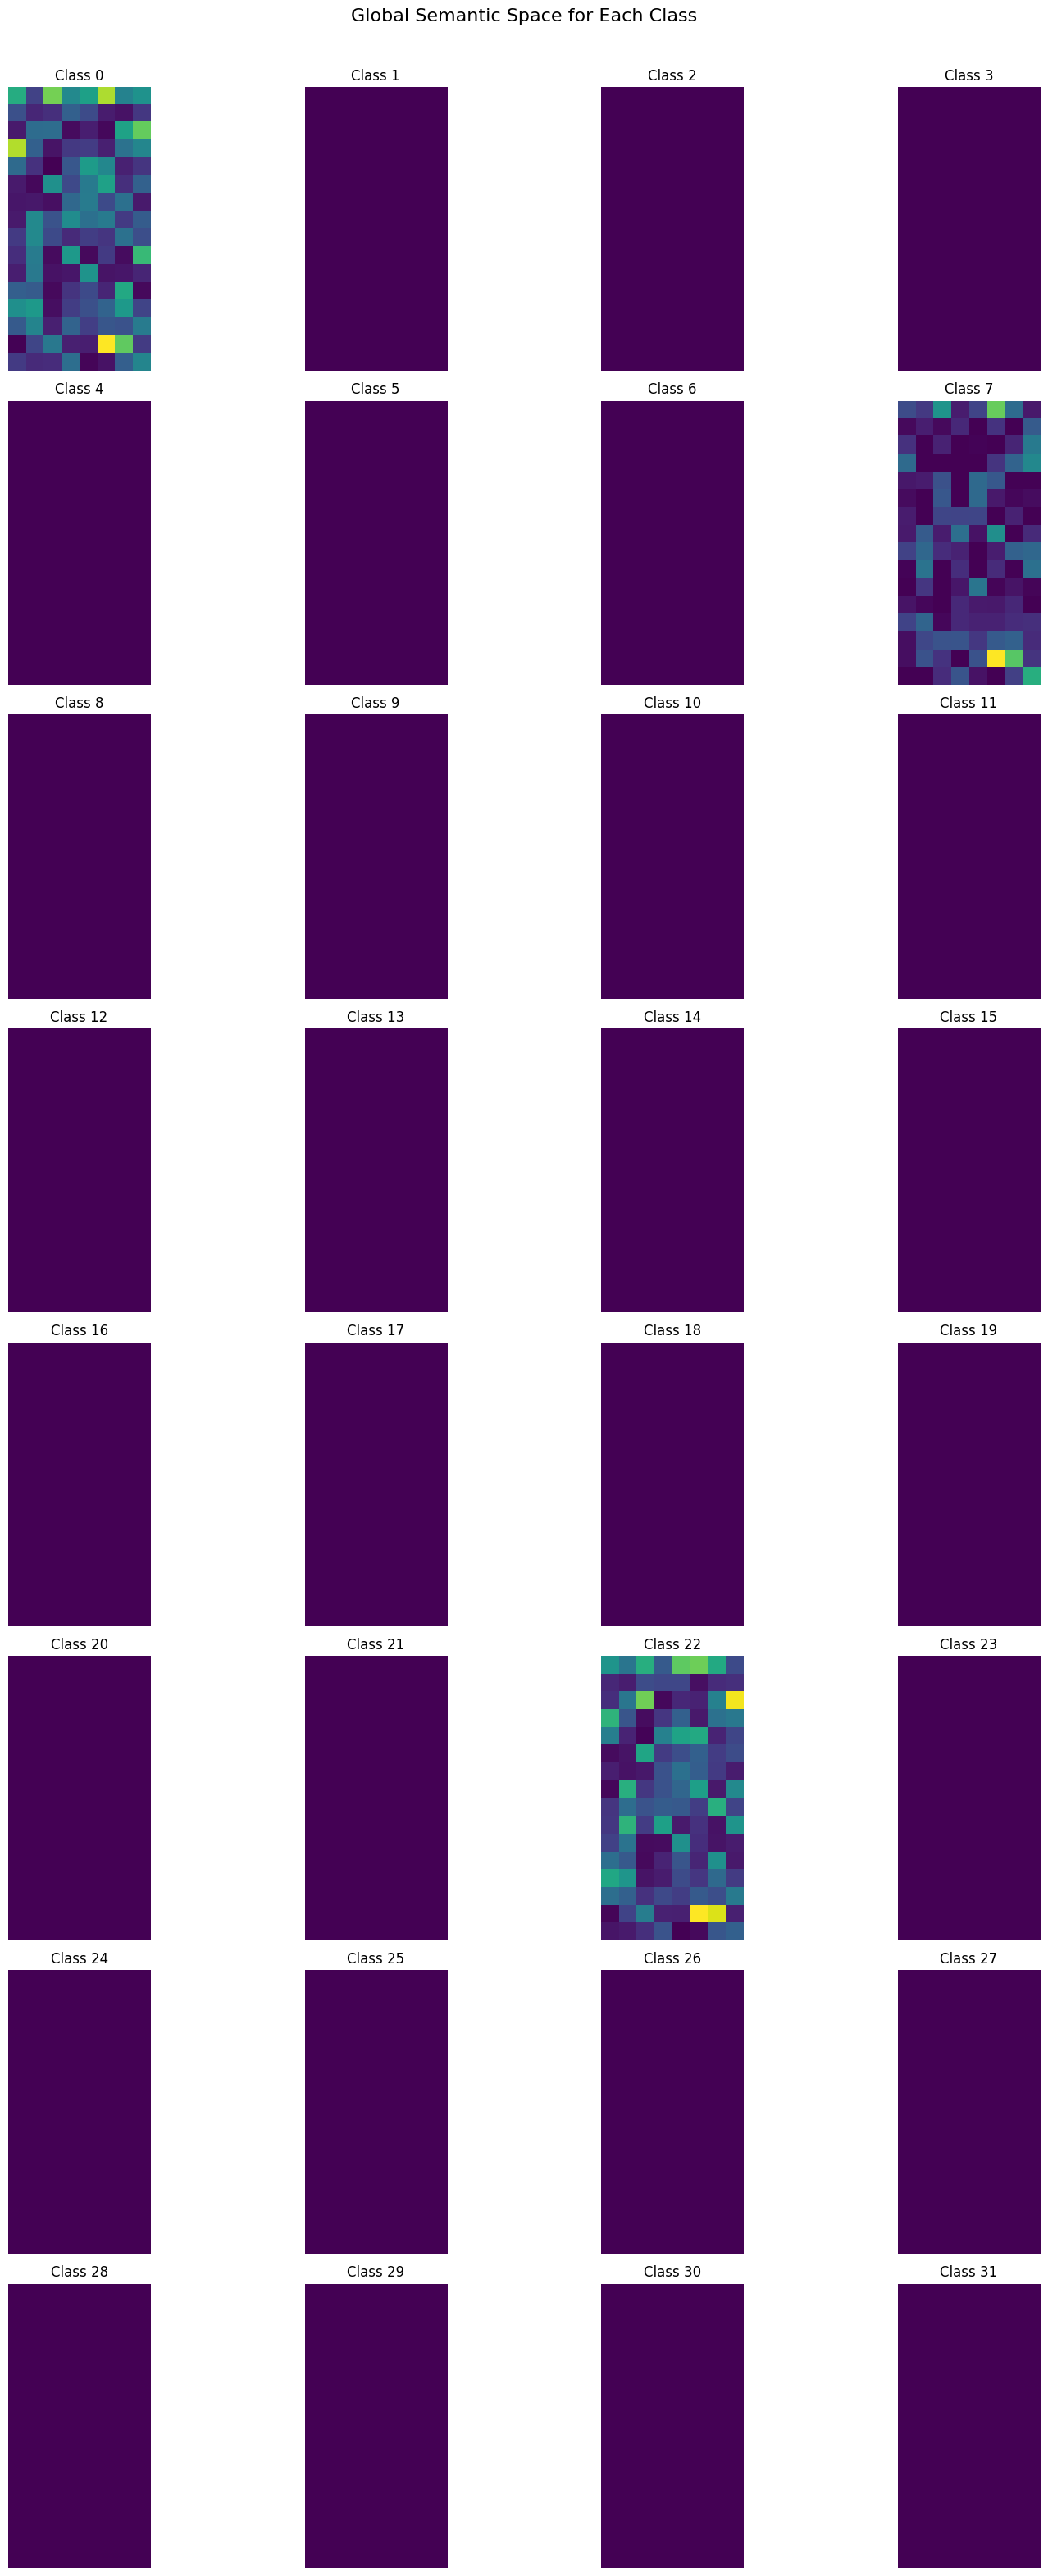

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def visualize_global_semantic_space(global_semantic_space, num_classes=32):
    fig, axes = plt.subplots(8, 4, figsize=(16, 32))
    fig.suptitle("Global Semantic Space for Each Class", fontsize=16)
    
    global_semantic_space_normalized = F.normalize(global_semantic_space, dim=1).cpu().numpy()
    
    for class_id in range(num_classes):
        ax = axes[class_id // 4, class_id % 4]
        embedding = global_semantic_space_normalized[class_id].reshape(16, 8)  
        ax.imshow(embedding, cmap='viridis')
        ax.set_title(f"Class {class_id}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

visualize_global_semantic_space(global_semantic_space)


In [17]:
print("Global Semantic Space Sample:", global_semantic_space[0][:5]) 

Global Semantic Space Sample: tensor([0.1564, 0.0519, 0.1987, 0.1196, 0.1438], device='mps:0')


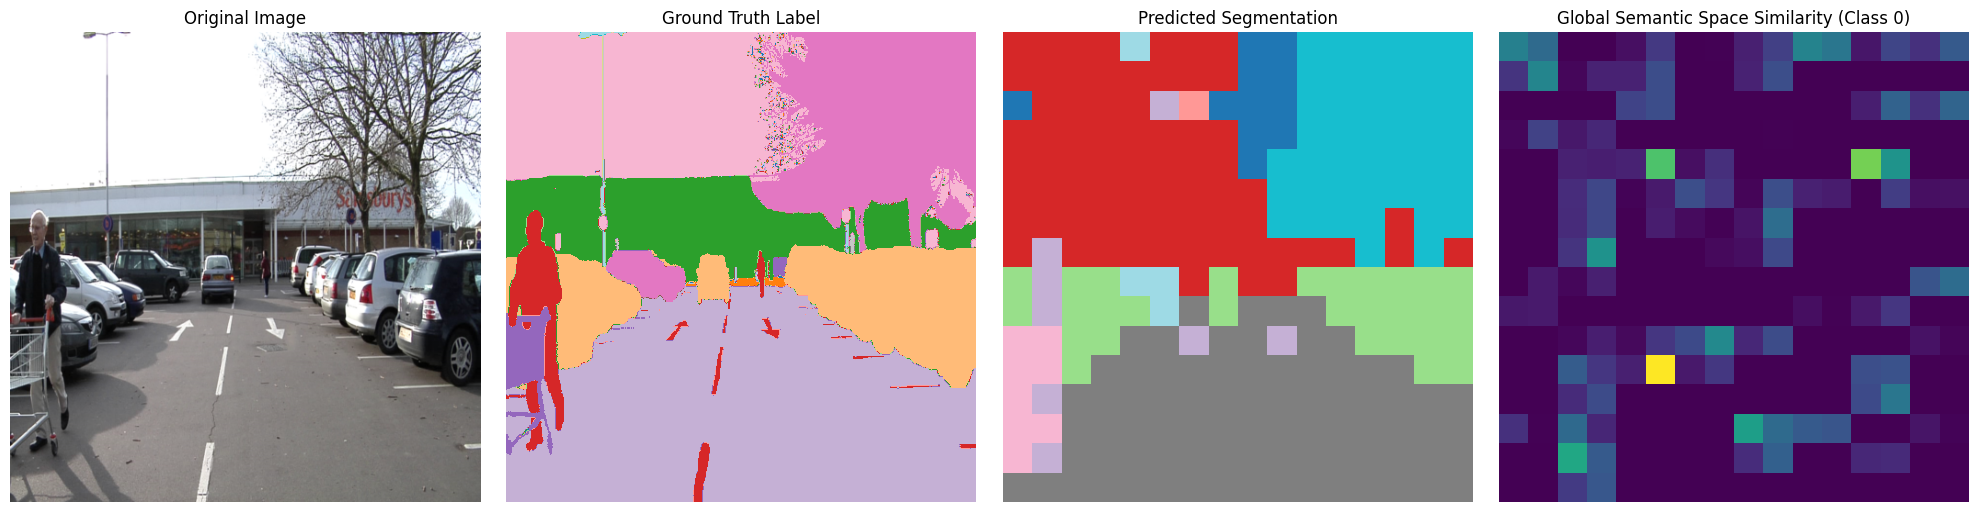

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(images, labels, predictions, embeddings, global_semantic_space, idx):
    """
    Visualizes the input image, ground truth labels, predictions, and global semantic space projections.
    """
    image = images[idx].cpu().numpy().transpose(1, 2, 0)  
    label = labels[idx].cpu().numpy()
    prediction = predictions[idx].argmax(dim=0).cpu().numpy()  
    embedding = embeddings[idx].cpu().numpy()
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(label, cmap='tab20')
    axes[1].set_title('Ground Truth Label')
    axes[1].axis('off')
    
    axes[2].imshow(prediction, cmap='tab20')
    axes[2].set_title('Predicted Segmentation')
    axes[2].axis('off')

    # Visualize embedding similarity to the global semantic space
    similarity_to_class_0 = np.dot(embedding.reshape(-1, 128), global_semantic_space[0].cpu().numpy()) 
    similarity_to_class_0 = similarity_to_class_0.reshape(embedding.shape[1], embedding.shape[2])
    
    axes[3].imshow(similarity_to_class_0, cmap='viridis')
    axes[3].set_title('Global Semantic Space Similarity (Class 0)')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for images, labels in camvid_dataloader:
        images, labels = images.to(device), labels.to(device)
        

        embeddings = feature_extractor(images)  
        predictions = feature_extractor(images) 
        
        visualize_predictions(images, labels, predictions, embeddings, global_semantic_space, idx=0)  
        break  
